In [1]:
!pip install transformers datasets evaluate

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import re
import torch
import torchtext
import gensim.downloader
from torch.utils.data import DataLoader
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.types import Device
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset
from prompt_toolkit import output
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import LinearLR
from torch.nn.init import xavier_uniform_
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, get_scheduler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import gc
# Hugging Face Dataset
from datasets import Dataset

# Model performance evaluation
import evaluate

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Data processing
import pandas as pd
import numpy as np

# Modeling
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler

# Progress bar
from tqdm.auto import tqdm

# Hugging Face Dataset
from datasets import Dataset

# Model performance evaluation
import evaluate

#Seed for reproducibility
import random

seed_value=42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

%matplotlib inline
plt.style.use('ggplot')

C:\ProgramData\Anaconda3\envs\pytorch_1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on the {device}.')

Training on the cuda.


# Loading data, EDA, data preprocessing

### Loading data

In [4]:
train_raw_data = pd.read_csv(filepath_or_buffer='https://raw.githubusercontent.com/wizard339/education/main/misis/nlp/text_classification/train.csv', index_col=0)
subm_raw_data = pd.read_csv(filepath_or_buffer='https://raw.githubusercontent.com/wizard339/education/main/misis/nlp/text_classification/test.csv')

print(f'Shape of train: {train_raw_data.shape}')
print(f'Shape of test: {subm_raw_data.shape}')

Shape of train: (41159, 2)
Shape of test: (3798, 2)


In [5]:
subm_raw_data = subm_raw_data.drop('id', axis=1)
subm_raw_data.head()

,Text
0,TRENDING: New Yorkers encounter empty supermar...
1,When I couldn't find hand sanitizer at Fred Me...
2,Find out how you can protect yourself and love...
3,#Panic buying hits #NewYork City as anxious sh...
4,#toiletpaper #dunnypaper #coronavirus #coronav...


### Working with missing data

Let's look at the data:


In [6]:
train_raw_data.head()

,Text,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [7]:
train_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41159 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       41158 non-null  object
 1   Sentiment  41155 non-null  object
dtypes: object(2)
memory usage: 964.7+ KB


We can see that there are rows with missing data. Let's look at them:

In [8]:
train_raw_data[train_raw_data['Sentiment'].isnull() == True]

,Text,Sentiment
33122,@PrivyCouncilCA #SocialDistancing isnÂt enoug...,NaN
NaN,Neutral,NaN
39204,@TanDhesi @foreignoffice @Afzal4Gorton @Expres...,NaN
Neutral,NaN,NaN


Let's drop these rows from our DataFrame because they don't carry much value and let's look at the data again:

In [9]:
train_raw_data = train_raw_data.dropna().reset_index(drop=True)
print(f'New shape of train: {train_raw_data.shape}')

New shape of train: (41155, 2)


In [10]:
train_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41155 entries, 0 to 41154
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       41155 non-null  object
 1   Sentiment  41155 non-null  object
dtypes: object(2)
memory usage: 643.2+ KB


Let's look at the lines of texts:

(array([ 530., 3268., 4924., 6560., 6257., 7495., 8516., 3053.,  529.,
          23.]),
 array([ 1. ,  7.3, 13.6, 19.9, 26.2, 32.5, 38.8, 45.1, 51.4, 57.7, 64. ]),
 <BarContainer object of 10 artists>)

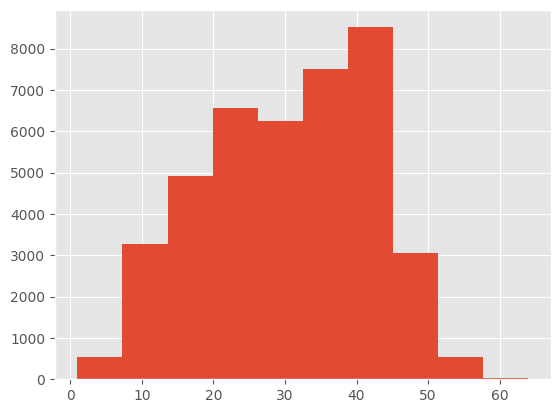

In [11]:
plt.hist([len(text.split()) for text in train_raw_data['Text']])

(array([ 24., 231., 356., 477., 543., 623., 701., 629., 199.,  15.]),
 array([ 2.,  8., 14., 20., 26., 32., 38., 44., 50., 56., 62.]),
 <BarContainer object of 10 artists>)

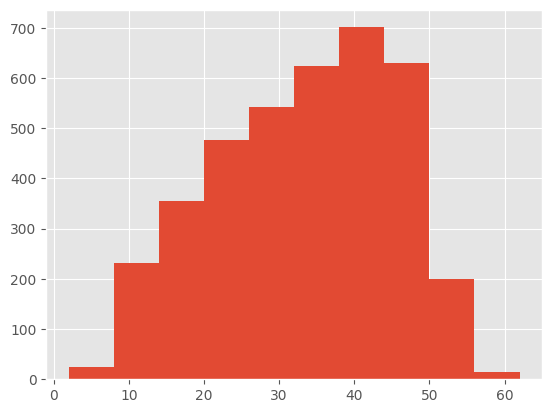

In [12]:
plt.hist([len(text.split()) for text in subm_raw_data['Text']])

There are no sequences that are too long and the distributions in the training and test samples are similar. It is good.

### Label encoding of target column

In [13]:
train_raw_data['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7711
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [14]:
le = LabelEncoder()
le.fit(train_raw_data['Sentiment'])
train_raw_data['Sentiment'] = le.transform(train_raw_data['Sentiment'])
train_raw_data.head(5)

,Text,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,3
1,advice Talk to your neighbours family to excha...,4
2,Coronavirus Australia: Woolworths to give elde...,4
3,My food stock is not the only one which is emp...,4
4,"Me, ready to go at supermarket during the #COV...",0


## For LSTM model

### Сleaning text from useless data

Let's look at the text more closely:

In [15]:
train_raw_data['Text'].sample(10, random_state=42).values

array(['So panic buying of soaps and toilet roll was bad enough, now the idiots are stockpiling alcohol ? whats wrong with people #CoronaVirus #StopPanicBuying #Covid_19',
       'I would place a large amount of money this is the guy buying 90 of the toilet paper',
       '"Saudi Arabia is bracing for an economic downturn as oil prices plummet due to the #coronavirus pandemic" https://t.co/PQ3eRX9euZ',
       '#Foodsecurity #coronavirus #covid19 \r\r\n1.Smooth flow of global trade will help secure food supply\r\r\n2.Monitoring food prices and markets\r\r\n3.Sharing relevant information transparently\r\r\n4.Supporting the vulnerable countries and populationsÂ\x85https://t.co/tTPmInVVgS https://t.co/Ums3Eueu6J',
       'I d like to know who is stockpiling eggs cheese and ice cream and why I m used to going without as our local Lidl has been running out of all kinds of stuff for years way before Drives me potty Going to the supermarket is like entering a lottery',
       'Whenever you tou

In [16]:
def text_cleaner(text: str) -> str:
    '''will clean from unicode, url, hashtags, numbers,
    nicknames, lower'''
    # text = re.sub(r'[.,#!$%\^&\*;:{}=\-_`~()]',r'',text) # punct.
    
    # text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)       
    text = re.sub(r'[^\x00-\x7f]', r'', text)# unicode

    text = re.sub(r'(\\[a-z])', r'', text)
    
    text = re.sub(r'http\S+', r'', text)# url
    
    # text = re.sub('@[A-Za-z0-9_-]+', r'', text)# nickname
    
    # text = re.sub(r'#([^\s]+)', r'\1', text)# hashtag symbol
    
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:',
                  '', text) # emoji
    
    text = ''.join([i for i in text if not i.isdigit()])# int.
    
    text = text.lower()
    return text

In [ ]:
train_raw_data['Text'] = train_raw_data['Text'].apply(text_cleaner)
subm_raw_data['Text'] = subm_raw_data['Text'].apply(text_cleaner)
train_raw_data['Text'].sample(10, random_state=42).values

array(['so panic buying of soaps and toilet roll was bad enough, now the idiots are stockpiling alcohol ? whats wrong with people #coronavirus #stoppanicbuying #covid_',
       'i would place a large amount of money this is the guy buying  of the toilet paper',
       '"saudi arabia is bracing for an economic downturn as oil prices plummet due to the #coronavirus pandemic" ',
       '#foodsecurity #coronavirus #covid \r\r\n.smooth flow of global trade will help secure food supply\r\r\n.monitoring food prices and markets\r\r\n.sharing relevant information transparently\r\r\n.supporting the vulnerable countries and populations ',
       'i d like to know who is stockpiling eggs cheese and ice cream and why i m used to going without as our local lidl has been running out of all kinds of stuff for years way before drives me potty going to the supermarket is like entering a lottery',
       'whenever you touch any object or surface outside your abode #washyourhands with #soapandwater\r\r\n\

### Tokenization

In [ ]:
tokenizer = get_tokenizer('basic_english')

def build_vocabulary(datasets):
  for dataset in datasets:
    for text in dataset['Text']:
      yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocabulary([train_raw_data, subm_raw_data]), specials=['<UNK>'])
vocab.set_default_index(vocab['<UNK>'])

In [ ]:
print(f'Vocabulary length: {vocab.__len__()}')

Vocabulary length: 50653


### Splitting of training data

We need to split our train_raw_data by train, validation and test samples in the proportions of 80:10:10.

However, our data contain texts for 5 classes, so it is necessary to keep stratification after their splitting.

In [ ]:
# first, we will split data by two samples: train and test in the proportion of 80:20
train_data, test_data = train_test_split(train_raw_data, test_size=0.2, stratify=train_raw_data['Sentiment'], random_state=42)
# then, we will split test data by two samples: validation and test in the proportion of 50:50 
val_data, test_data = train_test_split(test_data, test_size=0.5, stratify=test_data['Sentiment'], random_state=42)

Check the stratification:

In [ ]:
train_raw_data['Sentiment'].value_counts(normalize=True)

4    0.277536
2    0.240967
3    0.187365
1    0.160952
0    0.133179
Name: Sentiment, dtype: float64

In [ ]:
train_data['Sentiment'].value_counts(normalize=True)

4    0.277518
2    0.240979
3    0.187371
1    0.160946
0    0.133186
Name: Sentiment, dtype: float64

In [ ]:
val_data['Sentiment'].value_counts(normalize=True)

4    0.277521
2    0.240826
3    0.187363
1    0.161118
0    0.133171
Name: Sentiment, dtype: float64

In [ ]:
test_data['Sentiment'].value_counts(normalize=True)

4    0.277697
2    0.241011
3    0.187318
1    0.160836
0    0.133139
Name: Sentiment, dtype: float64

In [ ]:
print(f'Shape of the train_data: {train_data.shape}')
print(f'Shape of the val_data: {val_data.shape}')
print(f'Shape of the test_data: {test_data.shape}')
print(f'Shape of the finel_test_raw_data: {subm_raw_data.shape}')

Shape of the train_data: (32924, 2)
Shape of the val_data: (4115, 2)
Shape of the test_data: (4116, 2)
Shape of the finel_test_raw_data: (3798, 1)


# LSTM model

### Creating datasets

In [ ]:
train_dataset, val_dataset, test_dataset, subm_dataset = to_map_style_dataset(train_data.values), \
                                                               to_map_style_dataset(val_data.values), \
                                                               to_map_style_dataset(test_data.values), \
                                                               to_map_style_dataset(subm_raw_data.values)

MAX_WORDS  = 50
BATCH_SIZE = 1024

def vectorize_batch(batch):
  X, Y = list(zip(*batch))
  X = [vocab(tokenizer(text)) for text in X] # tokenize and map tokens to indexes
  X = [tokens+([0]*(MAX_WORDS - len(tokens))) if len(tokens) < MAX_WORDS else tokens[:MAX_WORDS] for tokens in X]
  return torch.tensor(X, dtype=torch.int32, device=device), torch.tensor(Y, device=device)

def vectorize_batch_for_submission(batch):
  X = [vocab(tokenizer(text[0])) for text in batch] # tokenize and map tokens to indexes
  X = [tokens+([0]*(MAX_WORDS - len(tokens))) if len(tokens) < MAX_WORDS else tokens[:MAX_WORDS] for tokens in X]
  return torch.tensor(X, dtype=torch.int32, device=device)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=vectorize_batch, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, collate_fn=vectorize_batch, shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=BATCH_SIZE, collate_fn=vectorize_batch, shuffle=True)
subm_loader  = DataLoader(subm_dataset , batch_size=BATCH_SIZE, collate_fn=vectorize_batch_for_submission)

### Building model

We are building a variation of the RNN: LSTM model.

After many attempts of training, our model will be multilayerd (the results are better only with regularization in the optimizer), bidirectional, with dropout and initialization of the hidden state using a Xavier's uniform distribution. LogSoftmax will be used as the activation function at the last level.

Adam with regularization will be used as an optimizer (the results without regularization were worse, and overfitting begins much early).

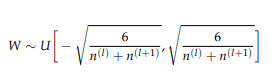

In [ ]:
EMBED_LEN  = 50
HIDDEN_DIM = 75
N_LAYERS   = 3

target_classes = train_raw_data['Sentiment'].unique()
train_on_gpu = torch.cuda.is_available()

class LSTMClassifier(nn.Module):
  def __init__(self):
    super(LSTMClassifier, self).__init__()
    self.emb_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=EMBED_LEN)
    self.lstm = nn.LSTM(input_size=EMBED_LEN, hidden_size=HIDDEN_DIM, num_layers=N_LAYERS, dropout=0.5, batch_first=True, bidirectional=True)
    self.fc = nn.Linear(in_features=HIDDEN_DIM*2, out_features=len(target_classes))
    self.softmax = nn.LogSoftmax(dim=1)
  
  def init_hidden(self, batch_size):
    '''Initializes hidden state'''
    # Create two new tensors with sizes n_layers x batch_size x n_hidden,
    # initialized to zero, for hidden state and cell state of LSTM
    weight = next(self.parameters()).data
    
    if (train_on_gpu):
      # 2*NUM_LAYERS is num_directions*num_layers (2 if bidirectional, else 1)
      hidden = (xavier_uniform_(weight.new(2*N_LAYERS, batch_size, HIDDEN_DIM)).cuda(),
                xavier_uniform_(weight.new(2*N_LAYERS, batch_size, HIDDEN_DIM)).cuda())
    else:
      # 2*NUM_LAYERS is num_directions*num_layers (2 if bidirectional, else 1)
      hidden = (xavier_uniform_(weight.new(2*N_LAYERS, batch_size, HIDDEN_DIM)),
                xavier_uniform_(weight.new(2*N_LAYERS, batch_size, HIDDEN_DIM)))
    return hidden

  def forward(self, X_batch, hidden):
    emb = self.emb_layer(X_batch)
    output, hidden = self.lstm(emb, hidden)
    output = self.fc(output[:, -1])
    output = self.softmax(output)
    return output, hidden

In [ ]:
lstm_classifier = LSTMClassifier()

lstm_classifier

LSTMClassifier(
  (emb_layer): Embedding(50653, 50)
  (lstm): LSTM(50, 75, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=150, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [ ]:
for layer in lstm_classifier.children():
  print(f'Layer: {layer}')
  print('Parameters: ')
  for param in layer.parameters():
    print(param.shape)
  print()

Layer: Embedding(50653, 50)
Parameters: 
torch.Size([50653, 50])

Layer: LSTM(50, 75, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
Parameters: 
torch.Size([300, 50])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])
torch.Size([300, 50])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])
torch.Size([300, 150])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])
torch.Size([300, 150])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])
torch.Size([300, 150])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])
torch.Size([300, 150])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])

Layer: Linear(in_features=150, out_features=5, bias=True)
Parameters: 
torch.Size([5, 150])
torch.Size([5])

Layer: LogSoftmax(dim=1)
Parameters: 



### Class for saving model and plots

In [ ]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion, path
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch}\n")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, path + 'best_model.pth')
            

def save_model(epochs, model, optimizer, criterion, path):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving final model...")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, path + 'final_model.pth')
    

def save_plots(valid_acc, train_loss, valid_loss, path):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(path + 'accuracy.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(path + 'loss.png')


save_best_model = SaveBestModel()

### Training loop and calculation validation loss and accuracy


In [ ]:
def CalcValLossAndAccuracy(model, loss_fn, val_loader):
  with torch.no_grad():
    Y_shuffled, Y_preds, losses = [], [], []
    for X, Y in val_loader:

      # initialise hidden state
      h = model.init_hidden(X.shape[0])

      preds, h = model(X, h)
      loss = loss_fn(preds, Y)
      losses.append(loss.item())

      Y_shuffled.append(Y)
      Y_preds.append(preds.argmax(dim=-1))

    Y_shuffled = torch.cat(Y_shuffled)
    Y_preds = torch.cat(Y_preds)

    valid_loss = torch.tensor(losses).cpu().mean()
    valid_acc = accuracy_score(Y_shuffled.cpu().detach().numpy(), Y_preds.cpu().detach().numpy())

    print(f'Valid Loss: {valid_loss:.3f}')
    print(f'Valid Acc : {valid_acc:.3f}')

    return valid_loss, valid_acc


def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, device, epochs=10, path='/checkpoints/'):
  train_losses, val_losses, val_accs = [], [], []
  for i in range(1, epochs+1):
    losses = []
    for X, Y in tqdm(train_loader):
      X.to(device)
      Y.to(device)
      model.to(device)

      # initialise hidden state
      h = model.init_hidden(X.shape[0])

      Y_preds, h = model(X, h)

      loss = loss_fn(Y_preds, Y)
      losses.append(loss.item())

      optimizer.zero_grad()

      loss.backward()
      optimizer.step()

    train_loss = torch.tensor(losses).mean()
    print(f'Train Loss: {train_loss:.3f}')
    valid_loss, valid_acc = CalcValLossAndAccuracy(model, loss_fn, val_loader)

    # save the best model
    save_best_model(valid_loss, i, model, optimizer, loss_fn, path)

    # append losses and accuracy to lists
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    val_accs.append(valid_acc)

  # save the trained model weights for a final time
  save_model(i, model, optimizer, loss_fn, path)
  # save the loss and accuracy plots
  save_plots(val_accs, train_losses, val_losses, path)

### Launching the model



100%|██████████| 33/33 [00:03<00:00,  8.61it/s]


Train Loss: 1.557
Valid Loss: 1.561
Valid Acc : 0.301

Best validation loss: 1.5608524084091187

Saving best model for epoch: 1



100%|██████████| 33/33 [00:02<00:00, 16.05it/s]


Train Loss: 1.516
Valid Loss: 1.509
Valid Acc : 0.316

Best validation loss: 1.509476900100708

Saving best model for epoch: 2



100%|██████████| 33/33 [00:02<00:00, 16.09it/s]


Train Loss: 1.470
Valid Loss: 1.411
Valid Acc : 0.362

Best validation loss: 1.4106650352478027

Saving best model for epoch: 3



100%|██████████| 33/33 [00:02<00:00, 15.99it/s]


Train Loss: 1.321
Valid Loss: 1.301
Valid Acc : 0.488

Best validation loss: 1.3010938167572021

Saving best model for epoch: 4



100%|██████████| 33/33 [00:02<00:00, 16.29it/s]


Train Loss: 1.083
Valid Loss: 1.018
Valid Acc : 0.609

Best validation loss: 1.0181021690368652

Saving best model for epoch: 5



100%|██████████| 33/33 [00:02<00:00, 16.25it/s]


Train Loss: 0.880
Valid Loss: 0.841
Valid Acc : 0.675

Best validation loss: 0.8411420583724976

Saving best model for epoch: 6



100%|██████████| 33/33 [00:02<00:00, 15.47it/s]


Train Loss: 0.723
Valid Loss: 0.873
Valid Acc : 0.686


100%|██████████| 33/33 [00:02<00:00, 16.31it/s]


Train Loss: 0.628
Valid Loss: 0.666
Valid Acc : 0.737

Best validation loss: 0.6664022207260132

Saving best model for epoch: 8



100%|██████████| 33/33 [00:02<00:00, 16.34it/s]


Train Loss: 0.527
Valid Loss: 0.729
Valid Acc : 0.757


100%|██████████| 33/33 [00:02<00:00, 16.27it/s]


Train Loss: 0.449
Valid Loss: 0.591
Valid Acc : 0.777

Best validation loss: 0.5907188653945923

Saving best model for epoch: 10



100%|██████████| 33/33 [00:02<00:00, 15.95it/s]


Train Loss: 0.399
Valid Loss: 0.750
Valid Acc : 0.773


100%|██████████| 33/33 [00:02<00:00, 16.28it/s]


Train Loss: 0.370
Valid Loss: 0.681
Valid Acc : 0.787


100%|██████████| 33/33 [00:02<00:00, 16.42it/s]


Train Loss: 0.314
Valid Loss: 0.724
Valid Acc : 0.794


100%|██████████| 33/33 [00:02<00:00, 16.36it/s]


Train Loss: 0.292
Valid Loss: 0.610
Valid Acc : 0.791


100%|██████████| 33/33 [00:02<00:00, 16.25it/s]


Train Loss: 0.272
Valid Loss: 0.732
Valid Acc : 0.793
Saving final model...


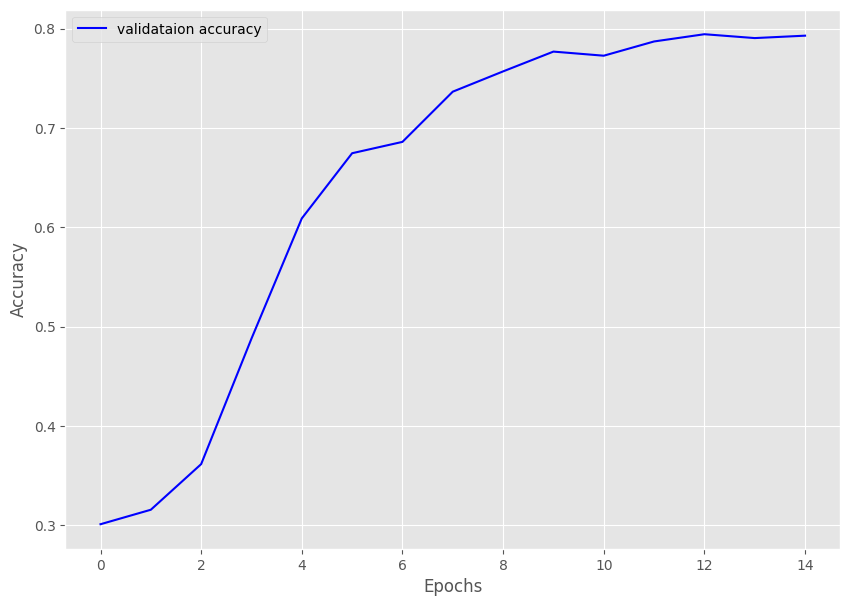

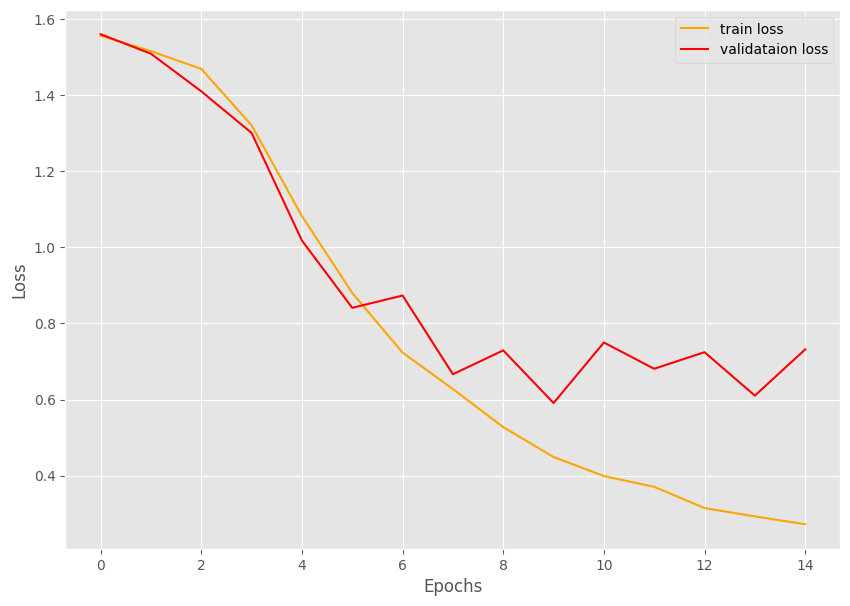

In [ ]:
EPOCHS  = 15
LR      = 1e-2
OPT     = Adam(lstm_classifier.parameters(), lr=LR, weight_decay=5e-5)
LOSS_FN = nn.CrossEntropyLoss()
MODEL   = lstm_classifier
PATH    = 'C:\\Users\\Home\\misis_projects\\classification_text_nlp\\checkpoints_lstm\\'

TrainModel(model=MODEL, loss_fn=LOSS_FN, optimizer=OPT, train_loader=train_loader, val_loader=val_loader, device=device, epochs=EPOCHS, path=PATH)

### Loading the saved model

In [ ]:
checkpoint = torch.load('C:\\Users\\Home\\misis_projects\\classification_text_nlp\\checkpoints_lstm\\final_model.pth')
MODEL.load_state_dict(checkpoint['model_state_dict'])
OPT.load_state_dict(checkpoint['optimizer_state_dict'])
EPOCHS = checkpoint['epoch']
LOSS_FN = checkpoint['loss']

# if we need to continue training
# MODEL.train()
# if we need to inference
MODEL.eval()

LSTMClassifier(
  (emb_layer): Embedding(50653, 50)
  (lstm): LSTM(50, 75, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=150, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)

### Test accuracy

In [ ]:
def MakePredictions(model, loader, device):
  Y_shuffled, Y_preds= [], []
  for X, Y in loader:
    X.to(device)
    Y.to(device)
    # initialise hidden state
    h = model.init_hidden(X.shape[0])
    preds, h = model(X, h)
    Y_preds.append(preds)
    Y_shuffled.append(Y)
  gc.collect()
  Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

  return Y_shuffled.cpu().detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1)

Y_actual, Y_preds = MakePredictions(lstm_classifier, test_loader, device)
Y_actual, Y_preds = torch.tensor(Y_actual).cpu(), torch.tensor(Y_preds).cpu()

C:\Users\Home\AppData\Local\Temp\ipykernel_11340\3140604675.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_actual, Y_preds = torch.tensor(Y_actual).cpu(), torch.tensor(Y_preds).cpu()


In [ ]:
target_classes_ = le.inverse_transform(target_classes)
print(f'Test Accuracy: {accuracy_score(Y_actual, Y_preds)}')
print('\nClassification report: ')
print(classification_report(Y_actual, Y_preds, target_names=target_classes_))
print('\nConfusion Matrix: ')
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy: 0.8124392614188533

Classification report: 
                    precision    recall  f1-score   support

           Neutral       0.86      0.76      0.81       548
          Positive       0.86      0.86      0.86       662
Extremely Negative       0.76      0.78      0.77       992
          Negative       0.89      0.84      0.86       771
Extremely Positive       0.76      0.82      0.79      1143

          accuracy                           0.81      4116
         macro avg       0.83      0.81      0.82      4116
      weighted avg       0.82      0.81      0.81      4116


Confusion Matrix: 
[[418   0 120   4   6]
 [  0 572   3   2  85]
 [ 63   3 770  27 129]
 [  3   4  51 644  69]
 [  2  88  64  49 940]]


### Final submissions

Making predictions for final submissions:

In [ ]:
def MakeSubmissions(model, loader, device):
    with torch.no_grad():
        Y_shuffled, Y_preds= [], []
        for X in loader:
            X.to(device)
            # initialise hidden state
            h = model.init_hidden(X.shape[0])
            preds, h = model(X, h)
            Y_preds.append(preds)
        gc.collect()
        Y_preds = torch.cat(Y_preds)

        return F.softmax(Y_preds, dim=-1).argmax(dim=-1)
    torch.cuda.empty_cache()

Y_preds = MakeSubmissions(lstm_classifier, subm_loader, device)
submission = pd.read_csv(filepath_or_buffer='https://raw.githubusercontent.com/wizard339/education/main/misis/nlp/text_classification/sample_submission.csv')
submission['Sentiment'] = le.inverse_transform(torch.tensor(Y_preds).cpu())
submission.head()

C:\Users\Home\AppData\Local\Temp\ipykernel_11340\2529566700.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  submission['Sentiment'] = le.inverse_transform(torch.tensor(Y_preds).cpu())


,id,Sentiment
0,787bc85b-20d4-46d8-84a0-562a2527f684,Negative
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,Positive
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Extremely Positive
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,Extremely Negative
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,Neutral


In [ ]:
# saving sabmission to '.csv' file
submission.to_csv('submission_lstm.csv', index=False, header=True)

### What else can be done to improve?



1.   Experiment with the regularization of the optimizer or try another optimizer.
2.   Experiment with the 'gain' parameter of the Xavier's initialization or try another method of the initialization hidden state.
3. Try another activation function.
4. Try using some pretrained embeddings.
5. Try using another tokenizators.
6. Try changing the text cleaning method.
7. Try deleting the stopwords.



## For transfer learning

In [ ]:
def text_cleaner(text: str) -> str:
    '''will clean from unicode, url, hashtags, numbers,
    nicknames, lower'''
    # text = re.sub(r'[.,#!$%\^&\*;:{}=\-_`~()]',r'',text) # punct.
    
    # text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)       
    text = re.sub(r'[^\x00-\x7f]', r'', text)# unicode

    text = re.sub(r'(\\[a-z])', r'', text)
    
    text = re.sub(r'http\S+', r'', text)# url
    
    text = re.sub('@[A-Za-z0-9_-]+', r'', text)# nickname
    
    text = re.sub(r'#([^\s]+)', r'\1', text)# hashtag symbol
    
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:',
                  '', text) # emoji
    
    text = ''.join([i for i in text if not i.isdigit()])# int.
    
    text = text.lower()
    return text

In [ ]:
train_raw_data['Text'] = train_raw_data['Text'].apply(text_cleaner)
final_test_raw_data['Text'] = final_test_raw_data['Text'].apply(text_cleaner)
train_raw_data['Text'].sample(10, random_state=42).values

array(['so panic buying of soaps and toilet roll was bad enough, now the idiots are stockpiling alcohol ? whats wrong with people coronavirus stoppanicbuying covid_',
       'i would place a large amount of money this is the guy buying  of the toilet paper',
       '"saudi arabia is bracing for an economic downturn as oil prices plummet due to the coronavirus pandemic" ',
       'foodsecurity coronavirus covid \r\r\n.smooth flow of global trade will help secure food supply\r\r\n.monitoring food prices and markets\r\r\n.sharing relevant information transparently\r\r\n.supporting the vulnerable countries and populations ',
       'i d like to know who is stockpiling eggs cheese and ice cream and why i m used to going without as our local lidl has been running out of all kinds of stuff for years way before drives me potty going to the supermarket is like entering a lottery',
       'whenever you touch any object or surface outside your abode washyourhands with soapandwater\r\r\n\r\r\nstay

In [ ]:
# first, we will split data by two samples: train and test in the proportion of 60:40
train_data, test_data = train_test_split(train_raw_data, test_size=0.2, stratify=train_raw_data['Sentiment'], random_state=42)
# then, we will split test data by two samples: validation and test in the proportion of 50:50 
val_data, test_data = train_test_split(test_data, test_size=0.5, stratify=test_data['Sentiment'], random_state=42)

In [ ]:
# Convert pyhton dataframe to Hugging Face arrow dataset
hg_train_data = Dataset.from_pandas(train_data)
hg_val_data = Dataset.from_pandas(val_data)
hg_test_data = Dataset.from_pandas(test_data)
hg_final_test_data = Dataset.from_pandas(final_test_raw_data)

In [ ]:
final_test_raw_data.head()

,id,Text
0,787bc85b-20d4-46d8-84a0-562a2527f684,trending new yorkers encounter empty supermark...
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,when i couldn't find hand sanitizer at fred me...
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,find out how you can protect yourself and love...
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,panic buying hits newyork city as anxious shop...
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,toiletpaper dunnypaper coronavirus coronavirus...


In [ ]:
hg_final_test_data[0]

{'id': '787bc85b-20d4-46d8-84a0-562a2527f684',
 'Text': 'trending new yorkers encounter empty supermarket shelves (pictured, wegmans in brooklyn), sold-out online grocers (foodkick, maelivery) as coronavirus-fearing shoppers stock up  '}

In [ ]:
hg_train_data[0]

{'Text': ' to everyone hoarding rice who until now doesnt eat rice, remember to donate it and all left over food youve hoarded to a food bank near you.  food waste should not be a side effect of covid- as a result of irrational panic buying.  coronavir',
 'Sentiment': 0,
 '__index_level_0__': 3730}

In [ ]:
# Tokenizer from a pretrained model
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Take a look at the tokenizer
tokenizer

BertTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
# Mapping between special tokens and their IDs.
print(f'The unknown token is {tokenizer.unk_token} and the ID for the unknown token is {tokenizer.unk_token_id}.')
print(f'The seperator token is {tokenizer.sep_token} and the ID for the seperator token is {tokenizer.sep_token_id}.')
print(f'The pad token is {tokenizer.pad_token} and the ID for the pad token is {tokenizer.pad_token_id}.')
print(f'The sentence level classification token is {tokenizer.cls_token} and the ID for the classification token is {tokenizer.cls_token_id}.')
print(f'The mask token is {tokenizer.mask_token} and the ID for the mask token is {tokenizer.mask_token_id}.')

The unknown token is [UNK] and the ID for the unknown token is 100.
The seperator token is [SEP] and the ID for the seperator token is 102.
The pad token is [PAD] and the ID for the pad token is 0.
The sentence level classification token is [CLS] and the ID for the classification token is 101.
The mask token is [MASK] and the ID for the mask token is 103.


In [ ]:
# Funtion to tokenize data
def tokenize_dataset(data):
    return tokenizer(data["Text"], 
                     max_length=50, 
                     truncation=True, 
                     padding="max_length")

# Tokenize the dataset
dataset_train = hg_train_data.map(tokenize_dataset)
dataset_val = hg_val_data.map(tokenize_dataset)
dataset_test = hg_test_data.map(tokenize_dataset)
dataset_final_test = hg_final_test_data.map(tokenize_dataset)

Map:   0%|          | 0/32924 [00:00<?, ? examples/s]

Map:   0%|          | 0/4115 [00:00<?, ? examples/s]

Map:   0%|          | 0/4116 [00:00<?, ? examples/s]

Map:   0%|          | 0/3798 [00:00<?, ? examples/s]

In [ ]:
# Take a look at the data
print(dataset_train)
print(dataset_val)
print(dataset_test)
print(dataset_final_test)

Dataset({
    features: ['Text', 'Sentiment', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 32924
})
Dataset({
    features: ['Text', 'Sentiment', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4115
})
Dataset({
    features: ['Text', 'Sentiment', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4116
})
Dataset({
    features: ['id', 'Text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3798
})


In [ ]:
# Remove the review and index columns because it will not be used in the model
dataset_train = dataset_train.remove_columns(["Text", "__index_level_0__"])
dataset_val = dataset_val.remove_columns(["Text", "__index_level_0__"])
dataset_test = dataset_test.remove_columns(["Text", "__index_level_0__"])
dataset_final_test = dataset_final_test.remove_columns(["Text", "id"])

# Rename label to labels because the model expects the name labels
dataset_train = dataset_train.rename_column("Sentiment", "labels")
dataset_val = dataset_val.rename_column("Sentiment", "labels")
dataset_test = dataset_test.rename_column("Sentiment", "labels")

# Change the format to PyTorch tensors
dataset_train.set_format("torch")
dataset_val.set_format("torch")
dataset_test.set_format("torch")
dataset_final_test.set_format("torch")

# Take a look at the data
print(dataset_train)
print(dataset_val)
print(dataset_test)
print(dataset_final_test)

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 32924
})
Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4115
})
Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4116
})
Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3798
})


In [ ]:
dataset_train[0]

{'labels': tensor(0),
 'input_ids': tensor([  101,  1106,  2490, 16358,  2881,  1158,  7738,  1150,  1235,  1208,
          2144,  1204,  3940,  7738,   117,  2676,  1106, 23969,  1122,  1105,
          1155,  1286,  1166,  2094,  1128,  2707, 16358, 26541,  1106,   170,
          2094,  3085,  1485,  1128,   119,  2094,  5671,  1431,  1136,  1129,
           170,  1334,  2629,  1104,  1884, 18312,   118,  1112,   170,   102]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1])}

In [ ]:
# Empty cache
torch.cuda.empty_cache()

BATCH_SIZE = 1024

# DataLoader
train_dataloader = DataLoader(dataset=dataset_train, shuffle=True, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(dataset=dataset_val, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(dataset=dataset_test, batch_size=BATCH_SIZE)
final_test_dataloader = DataLoader(dataset=dataset_final_test, batch_size=BATCH_SIZE)

In [ ]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
# Number of epochs
num_epochs = 5

# Number of training steps
num_training_steps = num_epochs * len(train_dataloader)

# Optimizer
optimizer = AdamW(params=model.parameters(), lr=5e-6)

# Set up the learning rate scheduler
lr_scheduler = get_scheduler(name="linear", 
                             optimizer=optimizer, 
                             num_warmup_steps=0, 
                             num_training_steps=num_training_steps)

# Use GPU if it is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Set the progress bar
progress_bar = tqdm(range(num_training_steps))

# Tells the model that we are training the model
model.train()
# Loop through the epochs
for epoch in range(num_epochs):
    # Loop through the batches
    for batch in train_dataloader:
        # Get the batch
        batch = {k: v.to(device) for k, v in batch.items()}
        # Compute the model output for the batch
        outputs = model(**batch)
        # Loss computed by the model
        loss = outputs.loss
        # backpropagates the error to calculate gradients
        loss.backward()
        # Update the model weights
        optimizer.step()
        # Learning rate scheduler
        lr_scheduler.step()
        # Clear the gradients
        optimizer.zero_grad()
        # Update the progress bar
        progress_bar.update(1)

  0%|          | 0/165 [00:00<?, ?it/s]

https://medium.com/grabngoinfo/transfer-learning-for-text-classification-using-pytorch-5e52045d55f8

# A simple transformer

### Preprocessing

Repeat some of the steps that were perfomed early:

In [ ]:
# Empty cache
torch.cuda.empty_cache()

In [ ]:
# first, we will split data by two samples: train and test in the proportion of 80:20
train_data, test_data = train_test_split(train_raw_data, test_size=0.2, stratify=train_raw_data['Sentiment'], random_state=42)
# then, we will split test data by two samples: validation and test in the proportion of 50:50 
val_data, test_data = train_test_split(test_data, test_size=0.5, stratify=test_data['Sentiment'], random_state=42)

print(f'Shape of the train_data: {train_data.shape}')
print(f'Shape of the val_data: {val_data.shape}')
print(f'Shape of the test_data: {test_data.shape}')
print(f'Shape of the finel_test_raw_data: {subm_raw_data.shape}')

train_dataset, val_dataset, test_dataset, subm_dataset = to_map_style_dataset(train_data.values), \
                                                               to_map_style_dataset(val_data.values), \
                                                               to_map_style_dataset(test_data.values), \
                                                               to_map_style_dataset(subm_raw_data.values)

MAX_WORDS  = 40
BATCH_SIZE = 1024

def vectorize_batch(batch):
  X, Y = list(zip(*batch))
  X = [vocab(tokenizer(text)) for text in X] # tokenize and map tokens to indexes
  X = [tokens+([0]*(MAX_WORDS - len(tokens))) if len(tokens) < MAX_WORDS else tokens[:MAX_WORDS] for tokens in X]
  return torch.tensor(X, dtype=torch.int32, device=device), torch.tensor(Y, device=device)

def vectorize_batch_for_submission(batch):
  X = [vocab(tokenizer(text[0])) for text in batch] # tokenize and map tokens to indexes
  X = [tokens+([0]*(MAX_WORDS - len(tokens))) if len(tokens) < MAX_WORDS else tokens[:MAX_WORDS] for tokens in X]
  return torch.tensor(X, dtype=torch.int32, device=device), torch.tensor(Y, device=device)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=vectorize_batch, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, collate_fn=vectorize_batch, shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=BATCH_SIZE, collate_fn=vectorize_batch, shuffle=True)
subm_loader  = DataLoader(subm_dataset , batch_size=BATCH_SIZE, collate_fn=vectorize_batch_for_submission)

Shape of the train_data: (32924, 2)
Shape of the val_data: (4115, 2)
Shape of the test_data: (4116, 2)
Shape of the finel_test_raw_data: (3798, 1)


### Creating model

In [ ]:
class ClsTransformer(nn.Module):
    """
    Transformer for classifying sequences
    """

    def __init__(self, emb, heads, depth, seq_length, num_tokens, num_classes, max_pool=True, dropout=0.0):
        """
        :param emb: Embedding dimension
        :param heads: nr. of attention heads
        :param depth: Number of transformer blocks
        :param seq_length: Expected maximum sequence length
        :param num_tokens: Number of tokens (usually words) in the vocabulary
        :param num_classes: Number of classes.
        :param max_pool: If true, use global max pooling in the last layer. If false, use global
                         average pooling.
        """
        super().__init__()
        self.num_tokens, self.max_pool = num_tokens, max_pool
        self.token_embedding = nn.Embedding(num_embeddings=num_tokens, embedding_dim=emb)
        self.pos_embedding = nn.Embedding(num_embeddings=seq_length, embedding_dim=emb)
        self.unify_embeddings = nn.Linear(2 * emb, emb)

        tblocks = []
        for i in range(depth):
            tblocks.append(
                TransformerBlock(emb=emb, heads=heads, seq_length=seq_length, dropout=dropout))
            
        self.tblocks = nn.Sequential(*tblocks)
        self.toprobs = nn.Linear(emb, num_classes)
        self.do = nn.Dropout(dropout)

    def forward(self, x):
        """
        :param x: A batch by sequence length integer tensor of token indices.
        :return: predicted log-probability vectors for each token based on the preceding tokens.
        """
        tokens = self.token_embedding(x)
        b, t, e = tokens.size()
        positions = self.pos_embedding(torch.arange(t, device=device))[None, :, :].expand(b, t, e)
        x = self.unify_embeddings(torch.cat((tokens, positions), dim=2).view(-1, 2 * e)).view(b, t, e)
        x = self.do(x)
        x = self.tblocks(x)
        x = x.max(dim=1)[0] if self.max_pool else x.mean(dim=1) # pool over the time dimension
        x = self.toprobs(x)
        return F.log_softmax(x, dim=1)


class SelfAttention(nn.Module):
    def __init__(self, emb, heads=8):
        """
        :param emb:
        :param heads:
        :param mask:
        """
        super().__init__()

        self.emb = emb
        self.heads = heads

        self.tokeys = nn.Linear(emb, emb * heads, bias=False)
        self.toqueries = nn.Linear(emb, emb * heads, bias=False)
        self.tovalues = nn.Linear(emb, emb * heads, bias=False)

        self.unifyheads = nn.Linear(heads * emb, emb)

    def forward(self, x):

        b, t, e = x.size()
        h = self.heads
        assert e == self.emb, f'Input embedding dim ({e}) should match layer embedding dim ({self.emb})'

        keys    = self.tokeys(x)   .view(b, t, h, e)
        queries = self.toqueries(x).view(b, t, h, e)
        values  = self.tovalues(x) .view(b, t, h, e)

        # compute scaled dot-product self-attention

        # - fold heads into the batch dimension
        keys = keys.transpose(1, 2).contiguous().view(b * h, t, e)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, e)
        values = values.transpose(1, 2).contiguous().view(b * h, t, e)

        # - get dot product of queries and keys, and scale
        dot = torch.bmm(queries, keys.transpose(1, 2))
        dot = dot / math.sqrt(e) # dot contains b*h  t-by-t matrices with raw self-attention logits

        assert dot.size() == (b*h, t, t), f'Matrix has size {dot.size()}, expected {(b*h, t, t)}.'

        dot = F.softmax(dot, dim=2) # dot now has row-wise self-attention probabilities

        # apply the self attention to the values
        out = torch.bmm(dot, values).view(b, h, t, e)

        # swap h, t back, unify heads
        out = out.transpose(1, 2).contiguous().view(b, t, h * e)

        return self.unifyheads(out)


class TransformerBlock(nn.Module):
    def __init__(self, emb, heads, seq_length, ff_hidden_mult=5, dropout=0.4):
        super().__init__()
        self.attention = SelfAttention(emb, heads=heads)
        self.norm1 = nn.LayerNorm(emb)
        self.norm2 = nn.LayerNorm(emb)
        self.ff = nn.Sequential(
            nn.Linear(emb, ff_hidden_mult * emb),
            nn.ReLU(),
            nn.Linear(ff_hidden_mult * emb, emb),
            nn.Linear(emb, ff_hidden_mult * emb),
            nn.ReLU(),
            nn.Linear(ff_hidden_mult * emb, emb),
        )
        self.do = nn.Dropout(dropout)

    def forward(self, x):
        attended = self.attention(x)
        x = self.norm1(attended + x)
        x = self.do(x)
        feedforward = self.ff(x)
        x = self.norm2(feedforward + x)
        x = self.do(x)
        return x       

### Training and evaluating

In [ ]:
EPOCHS  = 15
MODEL   = ClsTransformer(
                emb=50,
                heads=1,
                depth=6,
                seq_length=MAX_WORDS, 
                num_tokens=len(vocab),
                num_classes=5
            )
LR      = 1e-2
OPT     = AdamW(MODEL.parameters(), lr=LR, weight_decay=5e-2)
LR_SCHD = LinearLR(OPT, total_iters=(EPOCHS * len(train_loader)))
LOSS_FN = nn.CrossEntropyLoss()
PATH    = '/content/checkpoints/simple_transformer'

for epoch in range(1, EPOCHS + 1):
    # Training
    train_losses, val_losses, val_accs = [], [], []
    MODEL.train()
    for X, Y in tqdm(train_loader):
        X, Y, MODEL = X.to(device), Y.to(device), MODEL.to(device)

        Y_preds = MODEL(X)

        loss = LOSS_FN(Y_preds, Y)
        train_losses.append(loss)

        OPT.zero_grad()

        loss.backward()
        OPT.step()
    train_loss = torch.tensor(train_losses).mean()
    print(f'Train Loss: {train_loss:.3f}')

    # Evaluation
    MODEL.eval()
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [], [], []
        for X, Y in tqdm(val_loader):
            preds = MODEL(X)
            loss = LOSS_FN(preds, Y)
            losses.append(loss)

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds    = torch.cat(Y_preds)

        valid_loss = torch.tensor(losses).to(device).mean()
        valid_acc  = accuracy_score(
                        Y_shuffled.cpu().detach().numpy(),
                        Y_preds.cpu().detach().numpy()
                        )
        print(f'Valid Loss: {valid_loss:.3f}')
        print(f'Epoch: {epoch}, Valid Acc : {valid_acc:.3f}')
    
    LR_SCHD.step()

    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    val_accs.append(valid_acc)

100%|██████████| 33/33 [00:04<00:00,  7.12it/s]


Train Loss: 1.564


100%|██████████| 5/5 [00:00<00:00, 19.81it/s]


Valid Loss: 1.515
Epoch: 1, Valid Acc : 0.313


100%|██████████| 33/33 [00:03<00:00, 10.52it/s]


Train Loss: 1.470


100%|██████████| 5/5 [00:00<00:00, 32.05it/s]


Valid Loss: 1.420
Epoch: 2, Valid Acc : 0.372


100%|██████████| 33/33 [00:03<00:00, 10.43it/s]


Train Loss: 1.308


100%|██████████| 5/5 [00:00<00:00, 32.23it/s]


Valid Loss: 1.268
Epoch: 3, Valid Acc : 0.453


100%|██████████| 33/33 [00:03<00:00, 10.54it/s]


Train Loss: 1.126


100%|██████████| 5/5 [00:00<00:00, 32.67it/s]


Valid Loss: 1.097
Epoch: 4, Valid Acc : 0.522


100%|██████████| 33/33 [00:03<00:00, 10.47it/s]


Train Loss: 0.964


100%|██████████| 5/5 [00:00<00:00, 32.25it/s]


Valid Loss: 1.074
Epoch: 5, Valid Acc : 0.582


100%|██████████| 33/33 [00:03<00:00, 10.42it/s]


Train Loss: 0.819


100%|██████████| 5/5 [00:00<00:00, 32.15it/s]


Valid Loss: 1.016
Epoch: 6, Valid Acc : 0.610


100%|██████████| 33/33 [00:03<00:00, 10.53it/s]


Train Loss: 0.706


100%|██████████| 5/5 [00:00<00:00, 32.78it/s]


Valid Loss: 0.883
Epoch: 7, Valid Acc : 0.641


100%|██████████| 33/33 [00:03<00:00, 10.56it/s]


Train Loss: 0.602


100%|██████████| 5/5 [00:00<00:00, 32.46it/s]


Valid Loss: 0.964
Epoch: 8, Valid Acc : 0.635


100%|██████████| 33/33 [00:03<00:00, 10.46it/s]


Train Loss: 0.538


100%|██████████| 5/5 [00:00<00:00, 32.23it/s]


Valid Loss: 0.992
Epoch: 9, Valid Acc : 0.658


100%|██████████| 33/33 [00:03<00:00, 10.56it/s]


Train Loss: 0.452


100%|██████████| 5/5 [00:00<00:00, 32.46it/s]


Valid Loss: 1.066
Epoch: 10, Valid Acc : 0.636


100%|██████████| 33/33 [00:03<00:00, 10.45it/s]


Train Loss: 0.397


100%|██████████| 5/5 [00:00<00:00, 32.15it/s]


Valid Loss: 0.986
Epoch: 11, Valid Acc : 0.671


100%|██████████| 33/33 [00:03<00:00, 10.48it/s]


Train Loss: 0.320


100%|██████████| 5/5 [00:00<00:00, 31.95it/s]


Valid Loss: 1.105
Epoch: 12, Valid Acc : 0.660


100%|██████████| 33/33 [00:03<00:00, 10.57it/s]


Train Loss: 0.291


100%|██████████| 5/5 [00:00<00:00, 32.86it/s]


Valid Loss: 1.112
Epoch: 13, Valid Acc : 0.662


100%|██████████| 33/33 [00:03<00:00, 10.56it/s]


Train Loss: 0.234


100%|██████████| 5/5 [00:00<00:00, 32.27it/s]


Valid Loss: 1.028
Epoch: 14, Valid Acc : 0.665


100%|██████████| 33/33 [00:03<00:00, 10.22it/s]


Train Loss: 0.214


100%|██████████| 5/5 [00:00<00:00, 31.84it/s]

Valid Loss: 1.280
Epoch: 15, Valid Acc : 0.657


# HuggingFace BERT transformer

In [ ]:
# first, we will split data by two samples: train and test in the proportion of 80:20
train_data, test_data = train_test_split(train_raw_data, test_size=0.2, stratify=train_raw_data['Sentiment'], random_state=42)
# then, we will split test data by two samples: validation and test in the proportion of 50:50 
val_data, test_data = train_test_split(test_data, test_size=0.5, stratify=test_data['Sentiment'], random_state=42)

print(f'Shape of the train_data: {train_data.shape}')
print(f'Shape of the val_data: {val_data.shape}')
print(f'Shape of the test_data: {test_data.shape}')
print(f'Shape of the finel_test_raw_data: {subm_raw_data.shape}')

Shape of the train_data: (32924, 2)
Shape of the val_data: (4115, 2)
Shape of the test_data: (4116, 2)
Shape of the finel_test_raw_data: (3798, 1)


In [ ]:
# Convert pandas dataframe to Hugging Face arrow dataset
hg_train_data = Dataset.from_pandas(train_data)
hg_val_data = Dataset.from_pandas(val_data)
hg_test_data = Dataset.from_pandas(test_data)
hg_subm_data = Dataset.from_pandas(subm_raw_data)

print(hg_train_data)
print(hg_val_data)
print(hg_test_data)
print(hg_subm_data)

Dataset({
    features: ['Text', 'Sentiment', '__index_level_0__'],
    num_rows: 32924
})
Dataset({
    features: ['Text', 'Sentiment', '__index_level_0__'],
    num_rows: 4115
})
Dataset({
    features: ['Text', 'Sentiment', '__index_level_0__'],
    num_rows: 4116
})
Dataset({
    features: ['Text'],
    num_rows: 3798
})


In [ ]:
checkpoint = "LIALLIES/finetune-bert-base-cased"

# Tokenizer from a pretrained model
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Take a look at the tokenizer
tokenizer

BertTokenizerFast(name_or_path='LIALLIES/finetune-bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
# Mapping between special tokens and their IDs.
print(f'The unknown token is {tokenizer.unk_token} and the ID for the unknown token is {tokenizer.unk_token_id}.')
print(f'The seperator token is {tokenizer.sep_token} and the ID for the seperator token is {tokenizer.sep_token_id}.')
print(f'The pad token is {tokenizer.pad_token} and the ID for the pad token is {tokenizer.pad_token_id}.')
print(f'The sentence level classification token is {tokenizer.cls_token} and the ID for the classification token is {tokenizer.cls_token_id}.')
print(f'The mask token is {tokenizer.mask_token} and the ID for the mask token is {tokenizer.mask_token_id}.')

The unknown token is [UNK] and the ID for the unknown token is 100.
The seperator token is [SEP] and the ID for the seperator token is 102.
The pad token is [PAD] and the ID for the pad token is 0.
The sentence level classification token is [CLS] and the ID for the classification token is 101.
The mask token is [MASK] and the ID for the mask token is 103.


In [ ]:
# Funtion to tokenize data
def tokenize_function(data):
    return tokenizer(data["Text"],
                     max_length=40,
                     truncation=True)

# Tokenize the dataset
dataset_train = hg_train_data.map(tokenize_function, batched=True)
dataset_val = hg_val_data.map(tokenize_function, batched=True)
dataset_test = hg_test_data.map(tokenize_function, batched=True)
dataset_subm = hg_subm_data.map(tokenize_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# Take a look at the data
print(dataset_train)
print(dataset_val)
print(dataset_test)
print(dataset_subm)

Dataset({
    features: ['Text', 'Sentiment', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 32924
})
Dataset({
    features: ['Text', 'Sentiment', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4115
})
Dataset({
    features: ['Text', 'Sentiment', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4116
})
Dataset({
    features: ['Text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3798
})


In [ ]:
# Remove the review and index columns because it will not be used in the model
dataset_train = dataset_train.remove_columns(["Text", "__index_level_0__"])
dataset_val = dataset_val.remove_columns(["Text", "__index_level_0__"])
dataset_test = dataset_test.remove_columns(["Text", "__index_level_0__"])
dataset_subm = dataset_subm.remove_columns(["Text"])

# Rename label to labels because the model expects the name labels
dataset_train = dataset_train.rename_column("Sentiment", "labels")
dataset_val = dataset_val.rename_column("Sentiment", "labels")
dataset_test = dataset_test.rename_column("Sentiment", "labels")

# Change the format to PyTorch tensors
dataset_train.set_format("torch")
dataset_val.set_format("torch")
dataset_test.set_format("torch")
dataset_subm.set_format("torch")

# Take a look at the data
print(dataset_train)
print(dataset_val)
print(dataset_test)
print(dataset_subm)

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 32924
})
Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4115
})
Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4116
})
Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3798
})


In [ ]:
# Empty cache
torch.cuda.empty_cache()

BATCH_SIZE = 128

# DataLoader
train_dataloader = DataLoader(dataset=dataset_train, batch_size=BATCH_SIZE, collate_fn=data_collator,  shuffle=True)
val_dataloader   = DataLoader(dataset=dataset_val,   batch_size=BATCH_SIZE, collate_fn=data_collator)
test_dataloader  = DataLoader(dataset=dataset_test,  batch_size=BATCH_SIZE, collate_fn=data_collator)
subm_dataloader  = DataLoader(dataset=dataset_subm,  batch_size=BATCH_SIZE, collate_fn=data_collator)

In [ ]:
# inspect the batch
for batch in train_dataloader:
  break
{k: v.shape for k, v in batch.items()}

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'labels': torch.Size([128]),
 'input_ids': torch.Size([128, 40]),
 'token_type_ids': torch.Size([128, 40]),
 'attention_mask': torch.Size([128, 40])}

In [ ]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=5)
# model.to(device)

In [ ]:
# pass one batch to this model to make sure that everything is ok
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(1.6408, grad_fn=<NllLossBackward0>) torch.Size([128, 5])


In [ ]:
# Number of epochs
num_epochs = 5

# Number of training steps
num_training_steps = num_epochs * len(train_dataloader)

# Optimizer
optimizer = AdamW(params=model.parameters(), lr=3e-5)

# Set up the learning rate scheduler
lr_scheduler = get_scheduler(name="linear", 
                             optimizer=optimizer, 
                             num_warmup_steps=0, 
                             num_training_steps=num_training_steps)

print(f'Number of the training steps: {num_training_steps}')

Number of the training steps: 1290


In [ ]:
# Use GPU if it is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
print(device)

cuda


 20%|██        | 258/1290 [02:05<06:31,  2.64it/s]

Epoch: 1: {'recall': {'recall': 0.6942891859052248}, 'precision': {'precision': 0.6996470175668906}, 'f1': {'f1': 0.6948410849999913}, 'accuracy': {'accuracy': 0.6942891859052248}}


 40%|████      | 516/1290 [04:16<04:55,  2.62it/s]

Epoch: 2: {'recall': {'recall': 0.7285540704738761}, 'precision': {'precision': 0.7380199443649433}, 'f1': {'f1': 0.7287575781882405}, 'accuracy': {'accuracy': 0.7285540704738761}}


 60%|██████    | 774/1290 [06:26<03:17,  2.62it/s]

Epoch: 3: {'recall': {'recall': 0.732442284325638}, 'precision': {'precision': 0.7381027544557097}, 'f1': {'f1': 0.7339154430399957}, 'accuracy': {'accuracy': 0.732442284325638}}


 80%|████████  | 1032/1290 [08:46<01:38,  2.61it/s]

Epoch: 4: {'recall': {'recall': 0.740947752126367}, 'precision': {'precision': 0.7453086324837828}, 'f1': {'f1': 0.741729210924675}, 'accuracy': {'accuracy': 0.740947752126367}}


100%|██████████| 1290/1290 [12:03<00:00,  1.69it/s]

Epoch: 5: {'recall': {'recall': 0.7407047387606318}, 'precision': {'precision': 0.7432819122312416}, 'f1': {'f1': 0.7414850695279216}, 'accuracy': {'accuracy': 0.7407047387606318}}


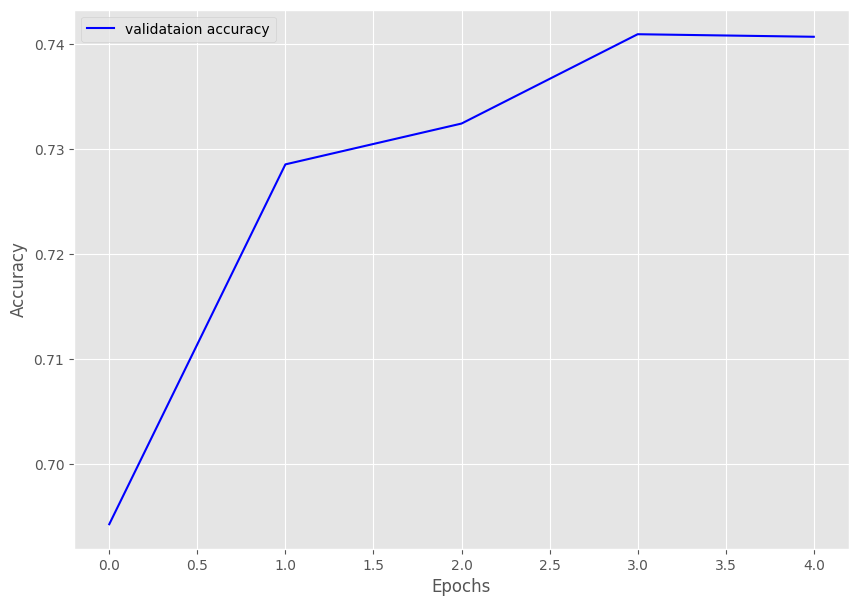

In [ ]:
recall_metric = evaluate.load('recall')
precision_metric = evaluate.load('precision')
f1_metric = evaluate.load('f1')
accuracy_metric = evaluate.load('accuracy')

# Set the progress bar
progress_bar = tqdm(range(num_training_steps))

best_accuracy = 0
prec_list_to_plot = []
rec_list_to_plot = []
f1_list_to_plot = []
acc_list_to_plot = []

# Loop through the epochs
for epoch in range(1, num_epochs + 1):
    # Tells the model that we are training the model
    model.train()
    # Loop through the batches
    for batch in train_dataloader:
        # Get the batch
        batch = {k: v.to(device) for k, v in batch.items()}
        # Compute the model output for the batch
        outputs = model(**batch)
        # Loss computed by the model
        loss = outputs.loss
        # backpropagates the error to calculate gradients
        loss.backward()
        # Update the model weights
        optimizer.step()
        # Learning rate scheduler
        lr_scheduler.step()
        # Clear the gradients
        optimizer.zero_grad()
        # Update the progress bar
        progress_bar.update(1)

    # Evaluation
    model.eval()
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
          outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        recall_metric.add_batch(predictions=predictions, references=batch['labels'])
        precision_metric.add_batch(predictions=predictions, references=batch['labels'])
        f1_metric.add_batch(predictions=predictions, references=batch['labels'])
        accuracy_metric.add_batch(predictions=predictions, references=batch['labels'])
    
    results = {
        'recall': recall_metric.compute(average='weighted'),
        'precision': precision_metric.compute(average='weighted'),
        'f1': f1_metric.compute(average='weighted'),
        'accuracy': accuracy_metric.compute()
    }
    
    print(
        f'Epoch: {epoch}:',
        {
            key: value
            for key, value in results.items()
        },
    )

    prec_list_to_plot.append(results['recall'])
    rec_list_to_plot.append(results['precision'])
    f1_list_to_plot.append(results['f1'])
    acc_list_to_plot.append(results['accuracy']['accuracy'])

    if results['accuracy']['accuracy'] > best_accuracy:
        best_accuracy = results['accuracy']['accuracy']
        model.save_pretrained('best_model')
    
model.save_pretrained('final_model')

# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(
    acc_list_to_plot, color='blue',
    linestyle='-', label='validataion accuracy'
)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy.png')

In [ ]:
progress_bar = tqdm(range(len(test_dataloader)))

# Evaluation
model.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
        
    recall_metric.add_batch(predictions=predictions, references=batch['labels'])
    precision_metric.add_batch(predictions=predictions, references=batch['labels'])
    f1_metric.add_batch(predictions=predictions, references=batch['labels'])
    accuracy_metric.add_batch(predictions=predictions, references=batch['labels'])
    progress_bar.update(1)
    
results = {
        'recall': recall_metric.compute(average='weighted'),
        'precision': precision_metric.compute(average='weighted'),
        'f1': f1_metric.compute(average='weighted'),
        'accuracy': accuracy_metric.compute()
    }
    
print(
        {
            key: value
            for key, value in results.items()
        },
    )


100%|██████████| 1290/1290 [37:50<00:00,  1.76s/it]

 97%|█████████▋| 32/33 [00:05<00:00,  5.83it/s]

{'recall': {'recall': 0.7405247813411079}, 'precision': {'precision': 0.742087036309162}, 'f1': {'f1': 0.740972533116875}, 'accuracy': {'accuracy': 0.7405247813411079}}


In [ ]:
# inspect the batch
for batch in subm_dataloader:
  break
{k: v.shape for k, v in batch.items()}

{'input_ids': torch.Size([128, 40]),
 'token_type_ids': torch.Size([128, 40]),
 'attention_mask': torch.Size([128, 40])}

In [ ]:
progress_bar = tqdm(range(len(subm_dataloader)))
# Submission
model.eval()
submissions = []
for batch in subm_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    submissions.append(predictions)
    progress_bar.update(1)

100%|██████████| 30/30 [00:04<00:00,  6.30it/s]

In [ ]:
submission = pd.read_csv(filepath_or_buffer='https://raw.githubusercontent.com/wizard339/education/main/misis/nlp/text_classification/sample_submission.csv')
submission['Sentiment'] = le.inverse_transform(torch.cat(submissions).cpu())
submission.head()

,id,Sentiment
0,787bc85b-20d4-46d8-84a0-562a2527f684,Negative
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,Positive
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Extremely Positive
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,Extremely Negative
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,Neutral


In [ ]:
# saving sabmission to '.csv' file
submission.to_csv('submission_bert.csv', index=False, header=True)

# Ensemble

In [17]:
def text_cleaner(text: str) -> str:
    '''will clean from unicode, url, hashtags, numbers,
    nicknames, lower'''
    # text = re.sub(r'[.,#!$%\^&\*;:{}=\-_`~()]',r'',text) # punct.
    
    # text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)       
    text = re.sub(r'[^\x00-\x7f]', r'', text)# unicode

    text = re.sub(r'(\\[a-z])', r'', text)
    
    text = re.sub(r'http\S+', r'', text)# url
    
    text = re.sub('@[A-Za-z0-9_-]+', r'', text)# nickname

    text = re.sub(r'#([^\s]+)', r'\1', text)# hashtag symbol
    
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:',
                  '', text) # emoji
    
    text = ''.join([i for i in text if not i.isdigit()])# int.
    
    text = text.lower()
    return text

In [18]:
train_raw_data['Text'] = train_raw_data['Text'].apply(text_cleaner)
subm_raw_data['Text'] = subm_raw_data['Text'].apply(text_cleaner)
train_raw_data['Text'].sample(10, random_state=42).values

array(['so panic buying of soaps and toilet roll was bad enough, now the idiots are stockpiling alcohol ? whats wrong with people coronavirus stoppanicbuying covid_',
       'i would place a large amount of money this is the guy buying  of the toilet paper',
       '"saudi arabia is bracing for an economic downturn as oil prices plummet due to the coronavirus pandemic" ',
       'foodsecurity coronavirus covid \r\r\n.smooth flow of global trade will help secure food supply\r\r\n.monitoring food prices and markets\r\r\n.sharing relevant information transparently\r\r\n.supporting the vulnerable countries and populations ',
       'i d like to know who is stockpiling eggs cheese and ice cream and why i m used to going without as our local lidl has been running out of all kinds of stuff for years way before drives me potty going to the supermarket is like entering a lottery',
       'whenever you touch any object or surface outside your abode washyourhands with soapandwater\r\r\n\r\r\nstay

In [19]:
# first, we will split data by two samples: train and test in the proportion of 80:20
train_data, test_data = train_test_split(train_raw_data, test_size=0.2, stratify=train_raw_data['Sentiment'], random_state=42)
# then, we will split test data by two samples: validation and test in the proportion of 50:50 
val_data, test_data = train_test_split(test_data, test_size=0.5, stratify=test_data['Sentiment'], random_state=42)

print(f'Shape of the train_data: {train_data.shape}')
print(f'Shape of the val_data: {val_data.shape}')
print(f'Shape of the test_data: {test_data.shape}')
print(f'Shape of the finel_test_raw_data: {subm_raw_data.shape}')

Shape of the train_data: (32924, 2)
Shape of the val_data: (4115, 2)
Shape of the test_data: (4116, 2)
Shape of the finel_test_raw_data: (3798, 1)


In [20]:
# Convert pandas dataframe to Hugging Face arrow dataset
hg_train_data = Dataset.from_pandas(train_data)
hg_val_data = Dataset.from_pandas(val_data)
hg_test_data = Dataset.from_pandas(test_data)
hg_subm_data = Dataset.from_pandas(subm_raw_data)

print(hg_train_data)
print(hg_val_data)
print(hg_test_data)
print(hg_subm_data)

Dataset({
    features: ['Text', 'Sentiment', '__index_level_0__'],
    num_rows: 32924
})
Dataset({
    features: ['Text', 'Sentiment', '__index_level_0__'],
    num_rows: 4115
})
Dataset({
    features: ['Text', 'Sentiment', '__index_level_0__'],
    num_rows: 4116
})
Dataset({
    features: ['Text'],
    num_rows: 3798
})


In [21]:
from transformers import AutoModelForMaskedLM

model_checkpoint = "bert-base-uncased"
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [23]:
text = "This is a great [MASK]."

inputs = tokenizer(text, return_tensors="pt")
token_logits = model(**inputs).logits
# Find the location of [MASK] and extract its logits
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
mask_token_logits = token_logits[0, mask_token_index, :]
# Pick the [MASK] candidates with the highest logits
top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

for token in top_5_tokens:
    print(f"'>>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}'")

'>>> This is a great idea.'
'>>> This is a great day.'
'>>> This is a great place.'
'>>> This is a great time.'
'>>> This is a great thing.'


In [24]:
# Funtion to tokenize data
def tokenize_function(data):
    result = tokenizer(data["Text"],
                    #  max_length=40,
                     truncation=True)
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    
    return result

# Tokenize the dataset
dataset_train = hg_train_data.map(tokenize_function, batched=True, remove_columns=['__index_level_0__', 'Sentiment', 'Text'])
dataset_val = hg_val_data.map(tokenize_function, batched=True, remove_columns=['__index_level_0__', 'Sentiment', 'Text'])
dataset_test = hg_test_data.map(tokenize_function, batched=True, remove_columns=['__index_level_0__', 'Sentiment', 'Text'])
dataset_subm = hg_subm_data.map(tokenize_function, batched=True, remove_columns=['Text'])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [25]:
# Take a look at the data
print(dataset_train)
print(dataset_val)
print(dataset_test)
print(dataset_subm)

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
    num_rows: 32924
})
Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
    num_rows: 4115
})
Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
    num_rows: 4116
})
Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
    num_rows: 3798
})


In [26]:
tokenizer.model_max_length

512

In [27]:
# Slicing produces a list of lists for each feature
tokenized_samples = dataset_train[:3]

for idx, sample in enumerate(tokenized_samples["input_ids"]):
    print(f"'>>> Review {idx} length: {len(sample)}'")

'>>> Review 0 length: 57'
'>>> Review 1 length: 43'
'>>> Review 2 length: 33'


In [28]:
concatenated_examples = {
    k: sum(tokenized_samples[k], []) for k in tokenized_samples.keys()
}
total_length = len(concatenated_examples["input_ids"])
print(f"'>>> Concatenated reviews length: {total_length}'")

'>>> Concatenated reviews length: 133'


In [29]:
chunk_size = 128

In [30]:
chunks = {
    k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
    for k, t in concatenated_examples.items()
}

for chunk in chunks["input_ids"]:
    print(f"'>>> Chunk length: {len(chunk)}'")

'>>> Chunk length: 128'
'>>> Chunk length: 5'


In [31]:
def group_texts(examples):
    # Concatenate all texts
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Compute length of concatenated texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result

In [32]:
lm_train_dataset = dataset_train.map(group_texts, batched=True)
lm_val_dataset = dataset_val.map(group_texts, batched=True)
lm_test_dataset = dataset_test.map(group_texts, batched=True)
lm_subm_dataset = dataset_subm.map(group_texts, batched=True)

In [33]:
print(lm_train_dataset)
print(lm_val_dataset)
print(lm_test_dataset)
print(lm_subm_dataset)

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
    num_rows: 10460
})
Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
    num_rows: 1304
})
Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
    num_rows: 1295
})
Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
    num_rows: 1337
})


In [34]:
tokenizer.decode(lm_train_dataset[1]['input_ids'])

'- buyers clear shelves [SEP] [CLS] pivoting quickly to changes is key to digital transformation. gearing up for more delivery demand & amp ; making it simple with call center & amp ; food parcels. big respect. coronavirus retail omnichannel grocery digitaltransformation [SEP] [CLS] pm gives an important update on coronavirus stayhomesavelives [SEP] [CLS] grocery stores should be spacing checkout lines, every other line should be closed at min, covid rule. many store have checkers backback, forcing customers w / in radius of frontlineworkers - this bad socialdistancing bendthecurve [SEP]'

In [35]:
tokenizer.decode(lm_train_dataset[1]['labels'])

'- buyers clear shelves [SEP] [CLS] pivoting quickly to changes is key to digital transformation. gearing up for more delivery demand & amp ; making it simple with call center & amp ; food parcels. big respect. coronavirus retail omnichannel grocery digitaltransformation [SEP] [CLS] pm gives an important update on coronavirus stayhomesavelives [SEP] [CLS] grocery stores should be spacing checkout lines, every other line should be closed at min, covid rule. many store have checkers backback, forcing customers w / in radius of frontlineworkers - this bad socialdistancing bendthecurve [SEP]'

In [36]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

In [37]:
samples = [lm_train_dataset[i] for i in range(2)]
for sample in samples:
    _ = sample.pop("word_ids")

for chunk in data_collator(samples)["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



'>>> [CLS] to [MASK] hoarding rice who until now doesnt eat rice, [MASK] to donate it and all left over food youve hoardedene a food bank near you. food waste should not be [MASK] side effect of covid - [MASK] a result of irrational panic buying. coronavir [SEP] [CLS] if your going to eat they empress [MASK] wet naps that have hand sanitizer on them. so ask for one or two in this time! covid [MASK] coronavirus thank you chick fil a [SEP] [CLS] watch [MASK] if [MASK] [MASK] one of those idiots who [MASK] panic buying food. thinkofothers corona sulfate nurse's despair as panic'

'>>> - buyers clear shelves [SEP] [CLS] pivoting quickly to changes is key [MASK] digital transformation. gearing up for more京 demand & amp ; making it [MASK] with call center & amp ; food parcels. [MASK] respect [MASK] coronavirus retail omnichannel grocery digitaltransformation [SEP] [CLS] pm gives an important update on coronavirus stayhomesa [MASK]ives [SEP] [CLS] grocery stores should be spa [MASK] checkout

In [38]:
import collections
import numpy as np

from transformers import default_data_collator

wwm_probability = 0.2


def whole_word_masking_data_collator(features):
    for feature in features:
        word_ids = feature.pop("word_ids")

        # Create a map between words and corresponding token indices
        mapping = collections.defaultdict(list)
        current_word_index = -1
        current_word = None
        for idx, word_id in enumerate(word_ids):
            if word_id is not None:
                if word_id != current_word:
                    current_word = word_id
                    current_word_index += 1
                mapping[current_word_index].append(idx)

        # Randomly mask words
        mask = np.random.binomial(1, wwm_probability, (len(mapping),))
        input_ids = feature["input_ids"]
        labels = feature["labels"]
        new_labels = [-100] * len(labels)
        for word_id in np.where(mask)[0]:
            word_id = word_id.item()
            for idx in mapping[word_id]:
                new_labels[idx] = labels[idx]
                input_ids[idx] = tokenizer.mask_token_id
        feature["labels"] = new_labels

    return default_data_collator(features)

In [39]:
samples = [lm_train_dataset[i] for i in range(2)]
batch = whole_word_masking_data_collator(samples)

for chunk in batch["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")


'>>> [CLS] to [MASK] hoarding rice who until now [MASK] [MASK] eat rice, [MASK] [MASK] donate it and all left over food youve hoarded to a food bank near you. food waste should not [MASK] [MASK] [MASK] effect of covid - as a result [MASK] irrational panic buying. coronavir [SEP] [CLS] if [MASK] going [MASK] [MASK] they [MASK] complementary wet naps that have hand [MASK] [MASK] [MASK] on them. so [MASK] for [MASK] or two in [MASK] time! covid? coronavirus thank [MASK] chick fil a [SEP] [CLS] watch this if you [MASK] one of those idiots who is panic buying food. thinkofothers coronavirus nurse's [MASK] as panic'

'>>> - buyers clear shelves [SEP] [CLS] pivoting [MASK] [MASK] changes [MASK] [MASK] to [MASK] transformation [MASK] [MASK] [MASK] up for more delivery [MASK] [MASK] amp ; making it simple with [MASK] center & amp ; [MASK] [MASK]. big respect. coronavirus retail omnichannel grocery digitaltransformation [SEP] [CLS] [MASK] gives an important [MASK] on coronavirus stayhomesaveliv

In [41]:
from transformers import TrainingArguments

batch_size = 32
# Show the training loss with every epoch
logging_steps = len(lm_train_dataset) // batch_size
model_name = model_checkpoint.split("/")[-1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-maskedlm",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    num_train_epochs=5,
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_strategy='epoch',
    # push_to_hub=True,
    fp16=True,
    logging_steps=logging_steps,
    # remove_unused_columns=False,
)

In [42]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_train_dataset,
    eval_dataset=lm_val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

Using cuda_amp half precision backend


In [43]:
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1304
  Batch size = 32


>>> Perplexity: 59.00


In [44]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
C:\ProgramData\Anaconda3\envs\pytorch_1\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 10460
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1635
  Number of trainable parameters = 109514298


Epoch,Training Loss,Validation Loss
1,3.236700,2.881245
2,2.930400,2.812131
3,2.849300,2.749974
4,2.791200,2.713703
5,2.748000,2.691617


The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1304
  Batch size = 32
Saving model checkpoint to bert-base-uncased-finetuned-maskedlm\checkpoint-327
Configuration saved in bert-base-uncased-finetuned-maskedlm\checkpoint-327\config.json
Configuration saved in bert-base-uncased-finetuned-maskedlm\checkpoint-327\generation_config.json
Model weights saved in bert-base-uncased-finetuned-maskedlm\checkpoint-327\pytorch_model.bin
tokenizer config file saved in bert-base-uncased-finetuned-maskedlm\checkpoint-327\tokenizer_config.json
Special tokens file saved in bert-base-uncased-finetuned-maskedlm\checkpoint-327\special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been i

TrainOutput(global_step=1635, training_loss=2.9103835137976786, metrics={'train_runtime': 448.4414, 'train_samples_per_second': 116.626, 'train_steps_per_second': 3.646, 'total_flos': 3441402927360000.0, 'train_loss': 2.9103835137976786, 'epoch': 5.0})

In [45]:
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1304
  Batch size = 32


>>> Perplexity: 14.23


## Fine-tuning BERT

In [46]:
# first, we will split data by two samples: train and test in the proportion of 80:20
train_data, test_data = train_test_split(train_raw_data, test_size=0.2, stratify=train_raw_data['Sentiment'], random_state=42)
# then, we will split test data by two samples: validation and test in the proportion of 50:50 
val_data, test_data = train_test_split(test_data, test_size=0.5, stratify=test_data['Sentiment'], random_state=42)

print(f'Shape of the train_data: {train_data.shape}')
print(f'Shape of the val_data: {val_data.shape}')
print(f'Shape of the test_data: {test_data.shape}')
print(f'Shape of the finel_test_raw_data: {subm_raw_data.shape}')

Shape of the train_data: (32924, 2)
Shape of the val_data: (4115, 2)
Shape of the test_data: (4116, 2)
Shape of the finel_test_raw_data: (3798, 1)


In [47]:
# Convert pandas dataframe to Hugging Face arrow dataset
hg_train_data = Dataset.from_pandas(train_data)
hg_val_data = Dataset.from_pandas(val_data)
hg_test_data = Dataset.from_pandas(test_data)
hg_subm_data = Dataset.from_pandas(subm_raw_data)

print(hg_train_data)
print(hg_val_data)
print(hg_test_data)
print(hg_subm_data)

Dataset({
    features: ['Text', 'Sentiment', '__index_level_0__'],
    num_rows: 32924
})
Dataset({
    features: ['Text', 'Sentiment', '__index_level_0__'],
    num_rows: 4115
})
Dataset({
    features: ['Text', 'Sentiment', '__index_level_0__'],
    num_rows: 4116
})
Dataset({
    features: ['Text'],
    num_rows: 3798
})


In [55]:
checkpoint = './bert-base-uncased-finetuned-maskedlm/checkpoint-1635/'

# Tokenizer from a pretrained model
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Take a look at the tokenizer
tokenizer

loading file vocab.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json


BertTokenizerFast(name_or_path='./bert-base-uncased-finetuned-maskedlm/checkpoint-1635/', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [56]:
# Mapping between special tokens and their IDs.
print(f'The unknown token is {tokenizer.unk_token} and the ID for the unknown token is {tokenizer.unk_token_id}.')
print(f'The seperator token is {tokenizer.sep_token} and the ID for the seperator token is {tokenizer.sep_token_id}.')
print(f'The pad token is {tokenizer.pad_token} and the ID for the pad token is {tokenizer.pad_token_id}.')
print(f'The sentence level classification token is {tokenizer.cls_token} and the ID for the classification token is {tokenizer.cls_token_id}.')
print(f'The mask token is {tokenizer.mask_token} and the ID for the mask token is {tokenizer.mask_token_id}.')

The unknown token is [UNK] and the ID for the unknown token is 100.
The seperator token is [SEP] and the ID for the seperator token is 102.
The pad token is [PAD] and the ID for the pad token is 0.
The sentence level classification token is [CLS] and the ID for the classification token is 101.
The mask token is [MASK] and the ID for the mask token is 103.


In [57]:
# Funtion to tokenize data
def tokenize_function(data):
    return tokenizer(data["Text"],
                     max_length=40,
                     truncation=True)

# Tokenize the dataset
dataset_train = hg_train_data.map(tokenize_function, batched=True)
dataset_val = hg_val_data.map(tokenize_function, batched=True)
dataset_test = hg_test_data.map(tokenize_function, batched=True)
dataset_subm = hg_subm_data.map(tokenize_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [58]:
# Take a look at the data
print(dataset_train)
print(dataset_val)
print(dataset_test)
print(dataset_subm)

Dataset({
    features: ['Text', 'Sentiment', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 32924
})
Dataset({
    features: ['Text', 'Sentiment', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4115
})
Dataset({
    features: ['Text', 'Sentiment', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4116
})
Dataset({
    features: ['Text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3798
})


In [59]:
# Remove the review and index columns because it will not be used in the model
dataset_train = dataset_train.remove_columns(["Text", "__index_level_0__"])
dataset_val = dataset_val.remove_columns(["Text", "__index_level_0__"])
dataset_test = dataset_test.remove_columns(["Text", "__index_level_0__"])
dataset_subm = dataset_subm.remove_columns(["Text"])

# Rename label to labels because the model expects the name labels
dataset_train = dataset_train.rename_column("Sentiment", "labels")
dataset_val = dataset_val.rename_column("Sentiment", "labels")
dataset_test = dataset_test.rename_column("Sentiment", "labels")

# Change the format to PyTorch tensors
dataset_train.set_format("torch")
dataset_val.set_format("torch")
dataset_test.set_format("torch")
dataset_subm.set_format("torch")

# Take a look at the data
print(dataset_train)
print(dataset_val)
print(dataset_test)
print(dataset_subm)

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 32924
})
Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4115
})
Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4116
})
Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3798
})


In [60]:
# Empty cache
torch.cuda.empty_cache()

BATCH_SIZE = 128

# DataLoader
train_dataloader = DataLoader(dataset=dataset_train, batch_size=BATCH_SIZE, collate_fn=data_collator,  shuffle=True)
val_dataloader   = DataLoader(dataset=dataset_val,   batch_size=BATCH_SIZE, collate_fn=data_collator)
test_dataloader  = DataLoader(dataset=dataset_test,  batch_size=BATCH_SIZE, collate_fn=data_collator)
subm_dataloader  = DataLoader(dataset=dataset_subm,  batch_size=BATCH_SIZE, collate_fn=data_collator)

In [61]:
# inspect the batch
for batch in train_dataloader:
  break
{k: v.shape for k, v in batch.items()}

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'labels': torch.Size([128]),
 'input_ids': torch.Size([128, 40]),
 'token_type_ids': torch.Size([128, 40]),
 'attention_mask': torch.Size([128, 40])}

In [62]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=5)
# model.to(device)

loading configuration file ./bert-base-uncased-finetuned-maskedlm/checkpoint-1635/config.json
Model config BertConfig {
  "_name_or_path": "./bert-base-uncased-finetuned-maskedlm/checkpoint-1635/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size"

In [63]:
# pass one batch to this model to make sure that everything is ok
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(1.6264, grad_fn=<NllLossBackward0>) torch.Size([128, 5])


In [64]:
# Number of epochs
num_epochs = 5

# Number of training steps
num_training_steps = num_epochs * len(train_dataloader)

# Optimizer
optimizer = AdamW(params=model.parameters(), lr=3e-5)

# Set up the learning rate scheduler
lr_scheduler = get_scheduler(name="linear", 
                             optimizer=optimizer, 
                             num_warmup_steps=0, 
                             num_training_steps=num_training_steps)

print(f'Number of the training steps: {num_training_steps}')

Number of the training steps: 1290


In [65]:
# Use GPU if it is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
print(device)

cuda


 20%|██        | 258/1290 [02:04<06:34,  2.62it/s]Configuration saved in ./bert-base-uncased-finetuned-mlm-clf/best_model\config.json


Epoch: 1: {'recall': {'recall': 0.6818955042527339}, 'precision': {'precision': 0.687587706724907}, 'f1': {'f1': 0.6799102298854092}, 'accuracy': {'accuracy': 0.6818955042527339}}


Model weights saved in ./bert-base-uncased-finetuned-mlm-clf/best_model\pytorch_model.bin
 40%|████      | 516/1290 [04:15<04:54,  2.62it/s]Configuration saved in ./bert-base-uncased-finetuned-mlm-clf/best_model\config.json


Epoch: 2: {'recall': {'recall': 0.7404617253948967}, 'precision': {'precision': 0.745146399238251}, 'f1': {'f1': 0.7408355470944636}, 'accuracy': {'accuracy': 0.7404617253948967}}


Model weights saved in ./bert-base-uncased-finetuned-mlm-clf/best_model\pytorch_model.bin
 60%|██████    | 774/1290 [06:25<03:17,  2.62it/s]Configuration saved in ./bert-base-uncased-finetuned-mlm-clf/best_model\config.json


Epoch: 3: {'recall': {'recall': 0.7552855407047387}, 'precision': {'precision': 0.7573407104820485}, 'f1': {'f1': 0.7559998563427298}, 'accuracy': {'accuracy': 0.7552855407047387}}


Model weights saved in ./bert-base-uncased-finetuned-mlm-clf/best_model\pytorch_model.bin
 80%|████████  | 1032/1290 [08:36<01:38,  2.62it/s]Configuration saved in ./bert-base-uncased-finetuned-mlm-clf/best_model\config.json


Epoch: 4: {'recall': {'recall': 0.7637910085054678}, 'precision': {'precision': 0.7674071665951083}, 'f1': {'f1': 0.7645407642289341}, 'accuracy': {'accuracy': 0.7637910085054678}}


Model weights saved in ./bert-base-uncased-finetuned-mlm-clf/best_model\pytorch_model.bin
100%|██████████| 1290/1290 [10:46<00:00,  2.62it/s]Configuration saved in ./bert-base-uncased-finetuned-mlm-clf/final_model\config.json


Epoch: 5: {'recall': {'recall': 0.7623329283110571}, 'precision': {'precision': 0.7640431494684127}, 'f1': {'f1': 0.7628529136748599}, 'accuracy': {'accuracy': 0.7623329283110571}}


Model weights saved in ./bert-base-uncased-finetuned-mlm-clf/final_model\pytorch_model.bin


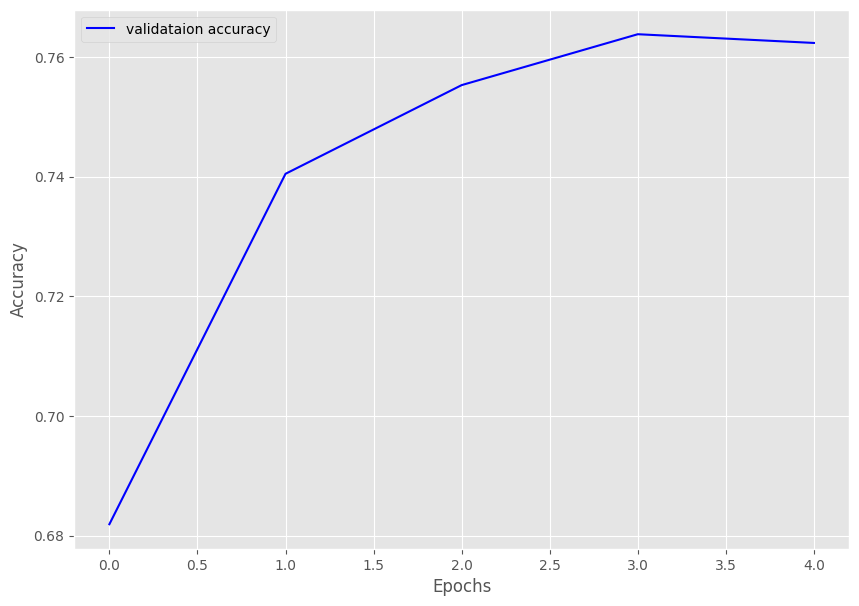

In [66]:
recall_metric = evaluate.load('recall')
precision_metric = evaluate.load('precision')
f1_metric = evaluate.load('f1')
accuracy_metric = evaluate.load('accuracy')

# Set the progress bar
progress_bar = tqdm(range(num_training_steps))

best_accuracy = 0
prec_list_to_plot = []
rec_list_to_plot = []
f1_list_to_plot = []
acc_list_to_plot = []

# Loop through the epochs
for epoch in range(1, num_epochs + 1):
    # Tells the model that we are training the model
    model.train()
    # Loop through the batches
    for batch in train_dataloader:
        # Get the batch
        batch = {k: v.to(device) for k, v in batch.items()}
        # Compute the model output for the batch
        outputs = model(**batch)
        # Loss computed by the model
        loss = outputs.loss
        # backpropagates the error to calculate gradients
        loss.backward()
        # Update the model weights
        optimizer.step()
        # Learning rate scheduler
        lr_scheduler.step()
        # Clear the gradients
        optimizer.zero_grad()
        # Update the progress bar
        progress_bar.update(1)

    # Evaluation
    model.eval()
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
          outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        recall_metric.add_batch(predictions=predictions, references=batch['labels'])
        precision_metric.add_batch(predictions=predictions, references=batch['labels'])
        f1_metric.add_batch(predictions=predictions, references=batch['labels'])
        accuracy_metric.add_batch(predictions=predictions, references=batch['labels'])
    
    results = {
        'recall': recall_metric.compute(average='weighted'),
        'precision': precision_metric.compute(average='weighted'),
        'f1': f1_metric.compute(average='weighted'),
        'accuracy': accuracy_metric.compute()
    }
    
    print(
        f'Epoch: {epoch}:',
        {
            key: value
            for key, value in results.items()
        },
    )

    prec_list_to_plot.append(results['recall'])
    rec_list_to_plot.append(results['precision'])
    f1_list_to_plot.append(results['f1'])
    acc_list_to_plot.append(results['accuracy']['accuracy'])

    if results['accuracy']['accuracy'] > best_accuracy:
        best_accuracy = results['accuracy']['accuracy']
        model.save_pretrained('./bert-base-uncased-finetuned-mlm-clf/best_model')
    
model.save_pretrained('./bert-base-uncased-finetuned-mlm-clf/final_model')

# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(
    acc_list_to_plot, color='blue',
    linestyle='-', label='validataion accuracy'
)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('./bert-base-uncased-finetuned-mlm-clf/accuracy.png')

In [67]:
progress_bar = tqdm(range(len(test_dataloader)))

# Evaluation
model.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
        
    recall_metric.add_batch(predictions=predictions, references=batch['labels'])
    precision_metric.add_batch(predictions=predictions, references=batch['labels'])
    f1_metric.add_batch(predictions=predictions, references=batch['labels'])
    accuracy_metric.add_batch(predictions=predictions, references=batch['labels'])
    progress_bar.update(1)
    
results = {
        'recall': recall_metric.compute(average='weighted'),
        'precision': precision_metric.compute(average='weighted'),
        'f1': f1_metric.compute(average='weighted'),
        'accuracy': accuracy_metric.compute()
    }
    
print(
        {
            key: value
            for key, value in results.items()
        },
    )


100%|██████████| 1290/1290 [10:52<00:00,  1.98it/s]

 97%|█████████▋| 32/33 [00:05<00:00,  5.77it/s]

{'recall': {'recall': 0.761418853255588}, 'precision': {'precision': 0.762964697562169}, 'f1': {'f1': 0.761989612980598}, 'accuracy': {'accuracy': 0.761418853255588}}


In [68]:
# inspect the batch
for batch in subm_dataloader:
  break
{k: v.shape for k, v in batch.items()}

{'input_ids': torch.Size([128, 40]),
 'token_type_ids': torch.Size([128, 40]),
 'attention_mask': torch.Size([128, 40])}

In [69]:
progress_bar = tqdm(range(len(subm_dataloader)))
# Submission
model.eval()
submissions = []
for batch in subm_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    submissions.append(predictions)
    progress_bar.update(1)

100%|██████████| 30/30 [00:04<00:00,  6.29it/s]

In [70]:
submission = pd.read_csv(filepath_or_buffer='https://raw.githubusercontent.com/wizard339/education/main/misis/nlp/text_classification/sample_submission.csv')
submission['Sentiment'] = le.inverse_transform(torch.cat(submissions).cpu())
submission.head()

,id,Sentiment
0,787bc85b-20d4-46d8-84a0-562a2527f684,Negative
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,Positive
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Extremely Positive
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,Negative
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,Neutral


In [71]:
# saving sabmission to '.csv' file
submission.to_csv('submission_bert_mlm_clf.csv', index=False, header=True)